# Camada equivalente com Norma mínima (Tikhonov de Ordem 0)

## Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import prism_mag
import eqlayer

## Gerando as coordenadas de observação

In [3]:
Nx = 200
Ny = 60
area = [-1500.,2500.,-2000.,2000.]
shape = (Nx,Ny)

In [4]:
x = np.linspace(area[0],area[1],num=Nx)
y = np.linspace(area[2],area[3],num=Ny) 
yc,xc = np.meshgrid(y,x)

In [5]:
voo = -100.
zc = voo*np.ones_like(xc)

In [6]:
coordinates = np.array([yc.ravel(),xc.ravel(),zc.ravel()])

## Gerando o modelo

In [7]:
intensidades = np.array([50.,50])

In [8]:
direcoes = np.array([[60.,-50.],
                     [60.,-50.]])

In [9]:
modelo = np.array([[-50.,50., -600.,250.,200.,350.],
                   [-600.,600.,700.,800.,200.,350.]])

### Cálculo das componentes do campo magnético

In [10]:
bz = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_z")

In [11]:
bx = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_x")

In [12]:
by = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_y")

### Anomalia de campo total aproximada

In [13]:
I0,D0 = 40.,-30. ## direçao do campo principal
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))
tfa = j0x*bx + j0y*by + j0z*bz

### Gerando um conjunto de dados observados com ruído Gaussiano

In [14]:
np.random.seed(seed=40)
std_noise = 0.01*np.max(np.abs(tfa))

r = np.random.normal(0.0, std_noise, tfa.size)

print ('%.3f nT' % std_noise)

8.520 nT


In [15]:
tfa_obs = tfa + r

## Visualização dos dados observados

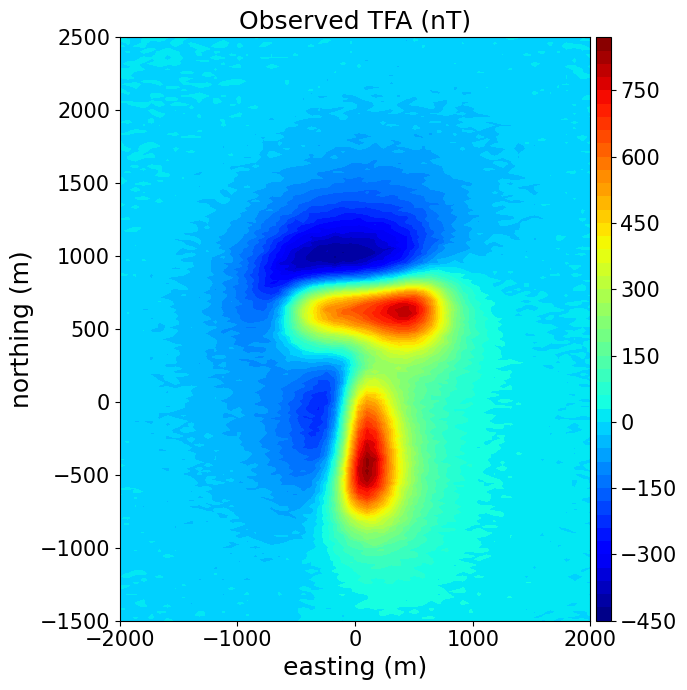

In [16]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.contourf(yc,xc,tfa_obs.reshape(shape),50,cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.show()

## Resolvendo o problema inverso 

### Direção do campo principal e direção de magnetização da camada

In [17]:
main_field = np.array([40.,-30.])
magnetization = np.array([60.,-50.])

### Gerando a camada equivalente

In [18]:
depth = 120.
zs = depth*np.ones_like(xc)
ys = yc
xs = xc

In [19]:
sources = np.array([ys.ravel(),xs.ravel(),zs.ravel()])

### Resolvendo a equação de mínimos quadrados regularizado com Tik-0

In [20]:
I = np.identity(xs.size)

In [21]:
G = eqlayer.sensitivity(coordinates,sources,main_field,magnetization)

In [22]:
determinante = np.linalg.det(np.dot(G.T,G))

In [23]:
determinante

0.0

In [30]:
mu = 100.

In [31]:
p = np.linalg.solve(np.dot(G.T,G) + mu*I,np.dot(G.T,tfa_obs))

In [32]:
tfa_pred = eqlayer.tfa(coordinates,sources,main_field,p,magnetization)

In [33]:
residuals = tfa_obs - tfa_pred
mean = np.mean(residuals)
std_deviation = np.std(residuals)

## Comparando dado observado com os dados gerado pela camada

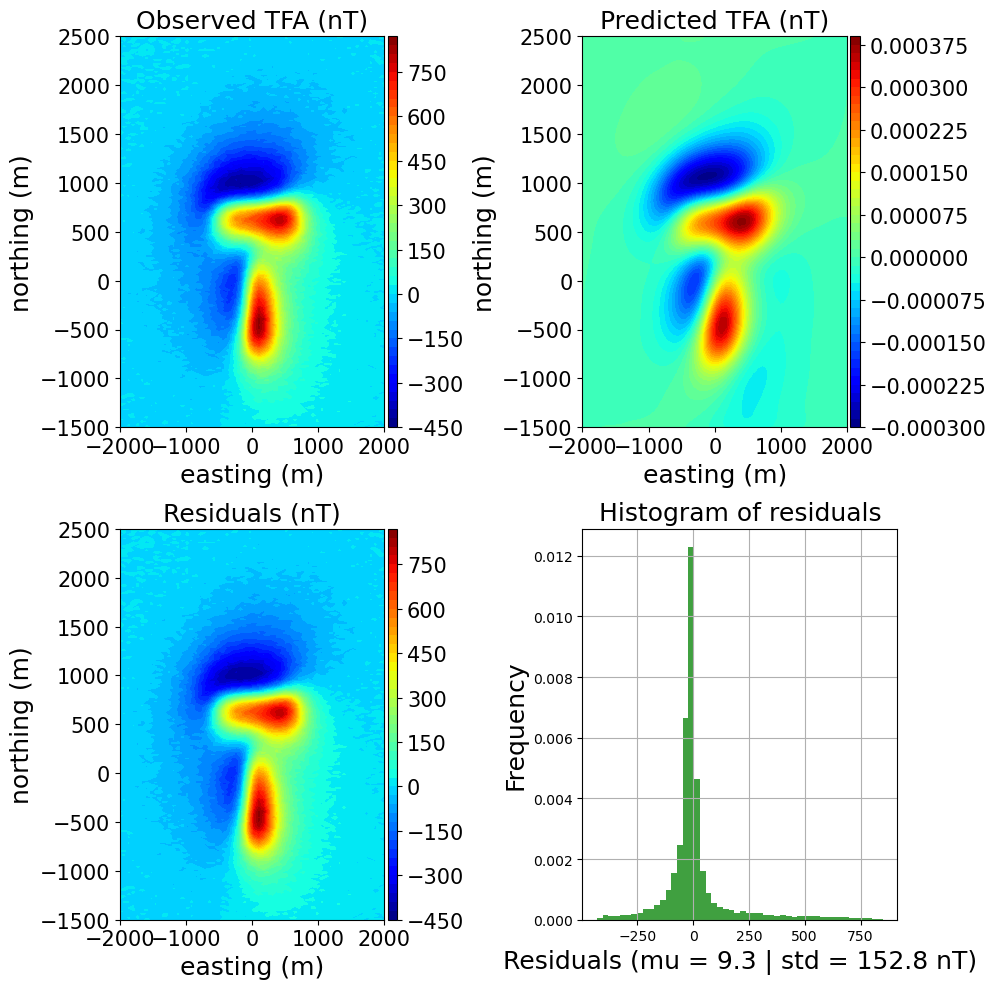

In [34]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(10,10), tight_layout=True)

plt.subplot(2,2,1)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.contourf(yc,xc,tfa_obs.reshape(shape),50,cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,2)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Predicted TFA (nT)', fontsize=title_font)
plt.contourf(yc,xc,tfa_pred.reshape(shape),50,cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,3)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Residuals (nT)', fontsize=title_font)
plt.contourf(yc,xc,residuals.reshape(shape),50,cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,4)
n, bins, patches = plt.hist(residuals, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Residuals (mu = %.1f | std = %.1f nT)' % (mean,std_deviation),fontsize = title_font)
plt.ylabel('Frequency',fontsize = title_font)
plt.title('Histogram of residuals',fontsize = title_font)
plt.grid(True)

plt.show()

### Distribuição de momentos magnéticos sobre a camada

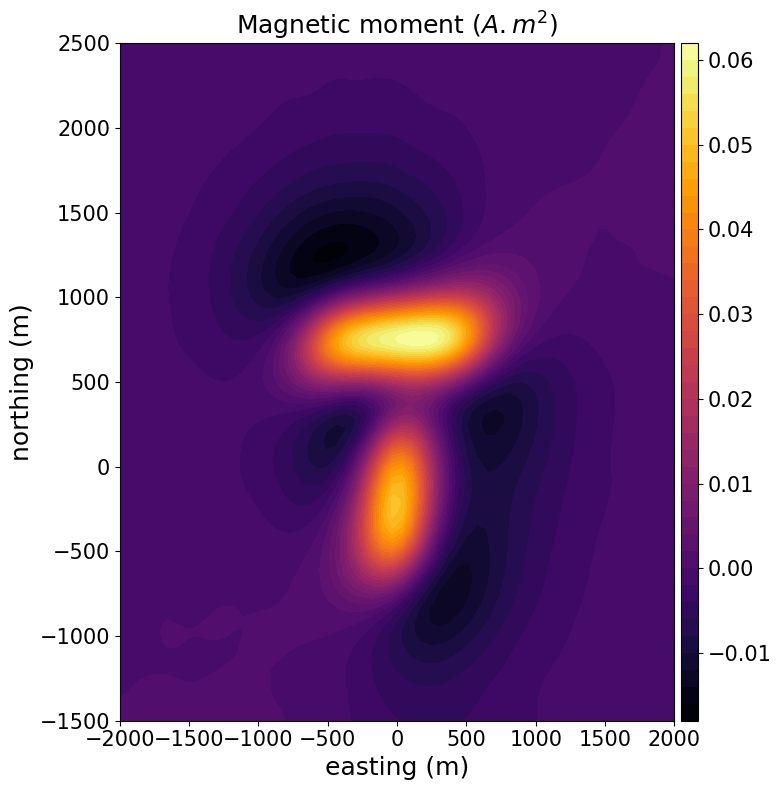

In [35]:
plt.figure(figsize=(8,8), tight_layout=True)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Magnetic moment ($A . m^2$)', fontsize=title_font)
plt.contourf(yc,xc,p.reshape(shape),50,cmap='inferno')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.show()